# Part II Project Notebook

## Extraction of Normal Modes and Plotting

In [4]:
from src.ProDyNMA import calculate_modes_gnm_cpu,calculate_modes_anm_cpu

calculate_modes_gnm_cpu("1A0A")
calculate_modes_anm_cpu("1A0A")

@> PDB file is found in working directory (1a0a.pdb.gz).
@> 1767 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Kirchhoff was built in 0.00s.
@> 20 modes were calculated in 0.03s.
@> PDB file is found in working directory (1a0a.pdb.gz).
@> 1767 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> Hessian was built in 0.02s.
@> WARNING More than 6 (18) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.19s.


(array([0.00011417, 0.00012049, 0.00040389, 0.0007291 , 0.00105616,
        0.00250762, 0.00256584, 0.00286281, 0.00364844, 0.00386225,
        0.00411906, 0.00476092, 0.00527282, 0.00590615, 0.00772188,
        0.00791318, 0.01442319, 0.01519949, 0.01615471, 0.01825176]),
 array([[-0.07293791,  0.06805842,  0.02752821, ...,  0.02016421,
         -0.03061516,  0.09928923],
        [-0.00792858,  0.0114592 , -0.0059184 , ..., -0.00711404,
          0.02776542, -0.03818654],
        [ 0.06814255, -0.07340574, -0.00416704, ...,  0.00366853,
         -0.04659892,  0.02569875],
        ...,
        [ 0.00367909, -0.00352286, -0.00105798, ..., -0.00237486,
         -0.0024073 ,  0.0045981 ],
        [-0.05414854,  0.05105482,  0.0092437 , ..., -0.02886343,
         -0.09384068,  0.01304715],
        [-0.04449609,  0.04191085,  0.00725349, ..., -0.02717193,
         -0.08410873,  0.01508994]]))

In [8]:
from src.SpringcraftNMA import calculate_normal_modes_gnm_from_file

gnm = calculate_normal_modes_gnm_from_file("./data/1aar.pdb", 10.0)
eigenval,eigenvec = gnm.eigen()
eigenval,eigenvec

(array([-3.62592067e-15,  8.35840555e-01,  1.37476241e+00,  2.77954396e+00,
         3.04252450e+00,  3.32308736e+00,  3.75049295e+00,  4.00000000e+00,
         4.22266578e+00,  5.34399375e+00,  5.67962040e+00,  6.29200642e+00,
         7.70947160e+00,  7.84793614e+00,  8.07814976e+00,  8.28355081e+00,
         8.57646580e+00,  8.95787901e+00,  9.04292180e+00,  9.19343589e+00,
         1.01663868e+01,  1.06179407e+01,  1.08476738e+01,  1.08573641e+01,
         1.09147084e+01,  1.12713746e+01,  1.14198478e+01,  1.15277626e+01,
         1.16796905e+01,  1.18954618e+01,  1.20029092e+01,  1.21406175e+01,
         1.22500527e+01,  1.23124025e+01,  1.24566279e+01,  1.25191691e+01,
         1.26619138e+01,  1.26964694e+01,  1.30054676e+01,  1.30361900e+01,
         1.30916848e+01,  1.32429060e+01,  1.35362322e+01,  1.36498735e+01,
         1.38914753e+01,  1.39270749e+01,  1.39636858e+01,  1.40747495e+01,
         1.41882935e+01,  1.43013593e+01,  1.43365334e+01,  1.45462030e+01,
         1.4

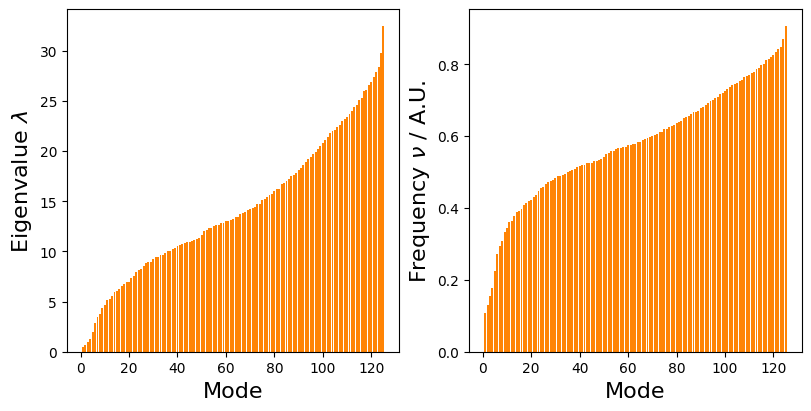

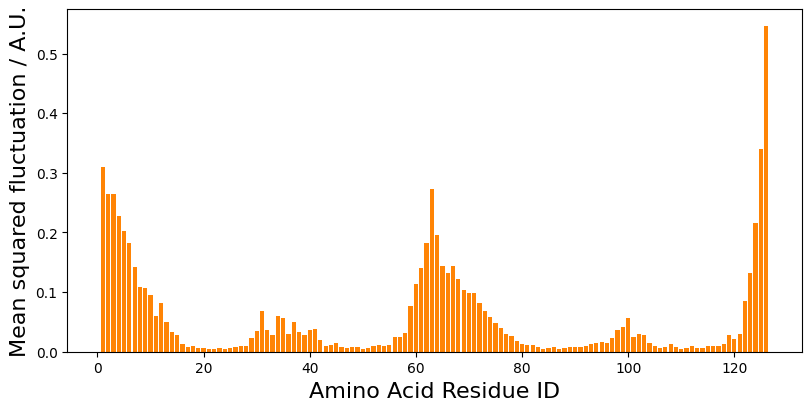

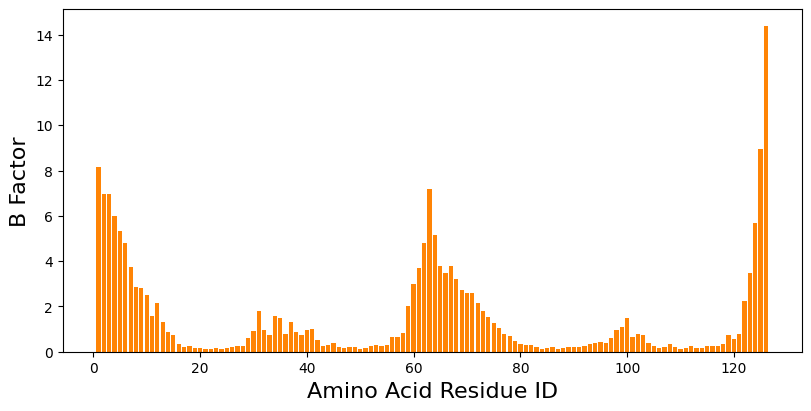

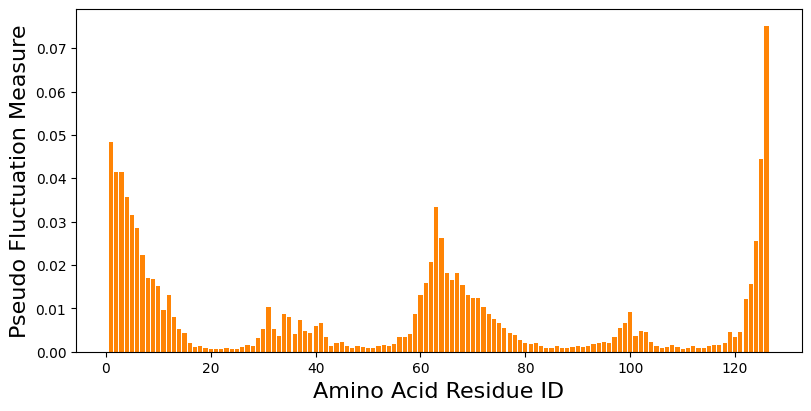

In [2]:
from src.SpringcraftNMA import plot_flexibility_value, plot_eigval_freq

plot_eigval_freq("1A0A", 10.0)
plot_flexibility_value("1A0A", 10.0, 10, "msqf")
plot_flexibility_value("1A0A", 10.0, 10, "bfact")
plot_flexibility_value("1A0A", 10.0, 10, "pseudo")

## Data Preparation for Training Phase

In [2]:
from src.DataProcessing import DataPreProcessorForGNM
x = DataPreProcessorForGNM(type_flexibility = "msqf")
x.from_file("./data/1aar.pdb")

Data(x=[152, 3], edge_index=[2, 2486], y=[384], node_type=[152], node_s=[152, 7], node_v=[152, 3, 3], edge_s=[2486, 32], edge_v=[2486, 1, 3], mask=[152])

### Loading Data

In [3]:
from libraries.lmdb_dataset import LMDBDataset

database = LMDBDataset("./data/pdb_data")
database

LMDBDataset(c:\Users\Mihailo\Desktop\Cambridge Part II\Part II Project\Part-II-Project-Protein-Dynamics-and-Flexibility\data\pdb_data)
	name:          pdb_data
	num_examples:  17,550
	size_on_disk:  2,104.70 MB

In [4]:
# To look at metadata

database.metadata.head()

,resolution,n_atoms,n_bonds,n_chains,n_models,r_free,r_work,deposition_date,release_date,method
2p0w,1.90,6410,5769,16,1,0.228,0.182,2007-03-01,2007-03-13,x-ray diffraction
1ogj,1.64,2750,2456,4,1,0.228,0.207,2003-05-06,2003-09-25,x-ray diffraction
1wc0,2.40,3247,3157,8,1,0.271,0.219,2004-11-05,2004-12-20,x-ray diffraction
2kzr,NaN,26620,26760,20,20,NaN,NaN,2010-06-23,2010-07-07,solution nmr
1gv1,2.50,9395,9059,8,1,0.305,0.216,2002-02-04,2002-02-20,x-ray diffraction


In [5]:
# You can access file like this
# by id:
database["5i4n"]
# via index:
database[0]

{'id': '2p0w',
 'structure': array([
 	Atom(np.array([125.653, -15.264,   3.862], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="N", element="N"),
 	Atom(np.array([124.756, -14.367,   4.653], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="CA", element="C"),
 	Atom(np.array([123.415, -14.216,   3.936], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="C", element="C"),
 	Atom(np.array([122.351, -14.145,   4.572], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="O", element="O"),
 	Atom(np.array([125.415, -13.004,   4.872], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="CB", element="C"),
 	Atom(np.array([123.481, -14.171,   2.607], dtype=float32), chain_id="A", res_id=24, ins_code="", res_name="GLU", hetero=False, atom_name="N", element="N"),
 	Atom(np.arr

In [6]:
import biotite.structure as struc
# To get specific chain, e.g. chain 'A', use
structure = database["5i4n"]["structure"]
protein_chain = structure[(structure.chain_id == "A") & struc.filter_amino_acids(structure)] 
protein_chain

array([
	Atom(np.array([-18.451,   0.162,  21.106], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="N", element="N"),
	Atom(np.array([-17.658,   0.39 ,  19.899], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-17.917,   1.767,  19.301], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="C", element="C"),
	Atom(np.array([-19.058,   2.236,  19.271], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="O", element="O"),
	Atom(np.array([-17.982,  -0.654,  18.823], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CB", element="C"),
	Atom(np.array([-17.147,  -1.902,  18.894], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CG", element="C"),
	Atom(np.array([-15.77 ,  -1.836,  18.99 

In [7]:
# To get c_alpha atoms of the protein backbone use
protein_backbone = protein_chain[(protein_chain.atom_name == "CA")]
protein_backbone

array([
	Atom(np.array([-17.658,   0.39 ,  19.899], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-16.908,   3.658,  18.091], dtype=float32), chain_id="A", res_id=538, ins_code="", res_name="HIS", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.519,   4.237,  15.382], dtype=float32), chain_id="A", res_id=539, ins_code="", res_name="LYS", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-18.046,   4.709,  11.938], dtype=float32), chain_id="A", res_id=540, ins_code="", res_name="ILE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.983,   6.463,   9.169], dtype=float32), chain_id="A", res_id=541, ins_code="", res_name="ARG", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-20.873,   4.278,   6.202], dtype=float32), chain_id="A", res_id=542, ins_code="", res_name="ASN", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.708,   7.025,   3.

In [9]:
import pandas as pd

labels = pd.read_csv("./data/enzyme_data/chain_functions.txt", names = ["chain_id", "label"])
labels[['id', 'chain']] = labels['chain_id'].str.split('.', 1, expand=True)
(labels["label"]==384).unique()


C:\Users\Mihailo\AppData\Local\Temp\ipykernel_13964\1125711676.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  labels[['id', 'chain']] = labels['chain_id'].str.split('.', 1, expand=True)


array([False])

In [10]:
x = DataPreProcessorForGNM(type_flexibility = "msqf")
x.from_loaded_structure(protein_chain, labels[(labels["id"] == "5i4n") & (labels["chain"] == "A")].label.iloc[0])

Data(x=[275, 3], edge_index=[2, 4864], y=[384], node_type=[275], node_s=[275, 7], node_v=[275, 3, 3], edge_s=[4864, 32], edge_v=[4864, 1, 3], mask=[275])

In [12]:
training_set = set(line.strip() for line in open('./data/enzyme_data/training.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))
testing_set = set(line.strip() for line in open('./data/enzyme_data/testing.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))
validating_set = set(line.strip() for line in open('./data/enzyme_data/validation.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))

In [13]:
def check_chain(chain: biotite.structure.AtomArray):
    ns = chain[chain.atom_name == 'N']
    cas = chain[chain.atom_name == 'CA']
    cs = chain[chain.atom_name == 'C']
    os = chain[chain.atom_name == 'O']
    if not (set(chain.res_name).issubset(set(STANDARD_AMINO_ACIDS))):
        return False
    if(np.array_equal(ns.res_id, cas.res_id) and np.array_equal(cas.res_id, cs.res_id) and np.array_equal(cs.res_id, os.res_id)):
        return True
    return False

In [15]:
%pip install progressbar


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\Mihailo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()


training_structures = []
for id in pbar(training_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            training_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()

testing_structures = []
for id in pbar(testing_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            testing_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
pbar = ProgressBar()

validating_structures = []
for id in pbar(validating_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            validating_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
print(len(training_structures))
print(len(testing_structures))
print(len(validating_structures))

In [ ]:
pbar = ProgressBar()

all_structures = []
for id in pbar(set(labels.chain_id).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            validating_structures.append(x.from_loaded_structure(protein_chain, labels[labels.chain_id == id].label.iloc[0]))

In [ ]:
len(all_structures)

In [ ]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

In [ ]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [ ]:
train_loader = DataLoader(validating_structures[:1], batch_size=2, shuffle=True)
val_loader = DataLoader(validating_structures, batch_size=2, shuffle=False)
test_loader = DataLoader(testing_structures, batch_size=2, shuffle=False)

In [ ]:
training_structures[0].edge_s.type()

In [ ]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=32, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # MLP `\psi` for computing messages `m_ij`
        # dims: (2d + d_e + 1) -> d
        self.mlp_msg = self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )  
        # MLP `\psi`
        self.mlp_upd_features = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        self.mlp_upd_coord = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, 1), BatchNorm1d(1), ReLU()
          )

    def forward(self, h, pos, edge_index, edge_s):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument 
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        
        out = self.propagate(edge_index, h=h, edge_s=edge_s, pos=pos)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write a custom `message()` function that takes as arguments the
    # source and destination node features, node coordiantes, and `edge_attr`.
    # Incorporate the coordinates `pos` into the message computation such
    # that the messages are invariant to rotations and translations.
    # This will ensure that the overall layer is also invariant.
    #
    def message(self, h_i, h_j, pos_i, pos_j, edge_s):
      """The `message()` function constructs messages from source nodes j 
       to destination nodes i for each edge (i, j) in `edge_index`.
    
       Args:
           h_i: (e, d) - destination node features
           h_j: (e, d) - source node features
           pos_i: (e, 3) - destination node coordinates
           pos_j: (e, 3) - source node coordinates
           edge_attr: (e, d_e) - edge features
        
       Returns:
           msg: (e, d) - messages `m_ij` passed through MLP `\psi`
      """ 
      msg = torch.concat([h_i, h_j, (pos_i-pos_j).norm(dim=1, p=2).reshape(-1,1), edge_s], dim=-1)
      return (self.mlp_msg(msg), self.mlp_upd_coord(msg)*(pos_i-pos_j))
    # ==========================================
    
    def aggregate(self, inputs, index, pos_i, pos_j):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        inputs_x, inputs_coord = inputs
        return (scatter(inputs_x, index, dim=self.node_dim, reduce=self.aggr),\
                scatter(inputs_coord, index, dim=self.node_dim, reduce=self.aggr))
    #
    def update(self, aggr_out, h, pos):
      """The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
      """
      upd_out_features = torch.cat([h, aggr_out[0]], dim=-1)
      return (self.mlp_upd_features(upd_out_features),pos+aggr_out[1])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class EGNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=8, edge_dim=32, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(torch.cat((data.node_s.to(torch.float32),data.node_type.reshape(-1,1).to(torch.float32)), dim=1)) # (n, d_n) -> (n, d)
        pos = data.x

        for conv in self.convs:
            h, pos = conv(h, pos, data.edge_index, data.edge_s) # (n, d) -> (n, d)

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = F.softmax(self.lin_pred(h_graph), dim=1) # (batch_size, d) -> (batch_size, 384)

        return out.view(-1)

In [ ]:
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (torch.argmax(y_pred) != torch.argmax(data.y)).sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [ ]:
model = EGNNModel(num_layers=4, emb_dim=64, in_dim=8, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
(best_val_error, test_error, train_time)